<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/CV-2025/blob/main/Week_12/Hands_on_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zero-Shot Image Recognition and Segmentation with CLIP

**Implementation** Note:  
This notebook was developed using methodologies suggested by  
the DeepSeek-V3 language model (DeepSeek, 2024).

In [1]:
# Install required libraries
!pip install -q transformers torch pillow requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.3 MB/s eta 0:00:00


In [2]:
import torch
from PIL import Image
import requests
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import gridspec
from torch.nn.functional import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np

from transformers import CLIPProcessor, CLIPModel, CLIPSegProcessor, CLIPSegForImageSegmentation

In [3]:
# Initialize model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

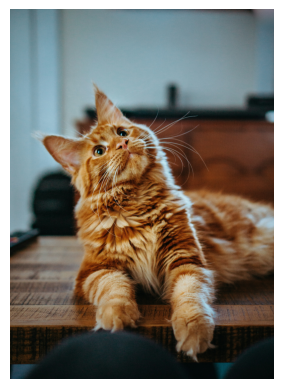

In [4]:
#@title Image Input Options {run: "auto"}
input_method = "URL" #@param ["URL", "Upload"]

if input_method == "URL":
    # Use example image or paste your own URL
    url = "https://images.unsplash.com/photo-1573865526739-10659fec78a5"  # Cat image
    image = Image.open(requests.get(url, stream=True).raw)
else:
    # Upload custom image
    from google.colab import files
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    image = Image.open(file_name)

# Display the image
plt.imshow(np.array(image))
plt.axis('off')
plt.show()

In [5]:
#@title Enter Candidate Labels {run: "auto"}
# Customize these labels for your use case
labels = ["cat", "dog", "wild animal", "car", "computer", "coffee mug"] #@param

# Add prompt engineering for better results (CLIP benefits from this)
processed_labels = [f"a photo of a {label}" for label in labels]

In [6]:
# Process inputs and get predictions
inputs = processor(
    text=processed_labels,
    images=image,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    outputs = model(**inputs)

# Calculate probabilities
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1).numpy()

In [7]:
# Simplified CLIP workflow
image_emb = model.get_image_features(inputs["pixel_values"])  # [1, 512]
text_emb = model.get_text_features(inputs["input_ids"])       # [4, 512] for 4 labels


Prediction probabilities:
cat            : 98.02%
dog            : 1.09%
wild animal    : 0.70%
car            : 0.01%
computer       : 0.06%
coffee mug     : 0.12%

Predicted label: cat


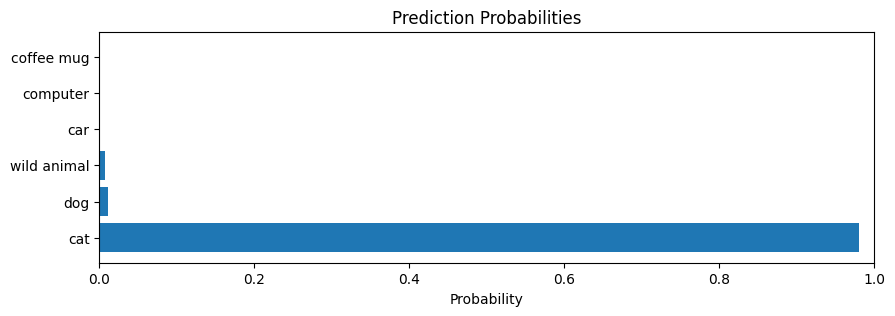

In [8]:
# Display results
print("\nPrediction probabilities:")
for label, prob in zip(labels, probs[0]):
    print(f"{label:<15}: {prob:.2%}")

predicted_label = labels[probs.argmax()]
print(f"\nPredicted label: {predicted_label}")

# Visualize probabilities
plt.figure(figsize=(10, 3))
plt.barh(labels, probs[0])
plt.title('Prediction Probabilities')
plt.xlabel('Probability')
plt.xlim([0, 1])
plt.show()

In [14]:
# # Similarity calculation (cosine similarity)
# logits_per_image = image_emb @ text_emb.T * model.logit_scale.exp()  # [1, 4]
# probs = logits_per_image.softmax(dim=-1)

## Segmentation with CLIPSeg

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/603M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


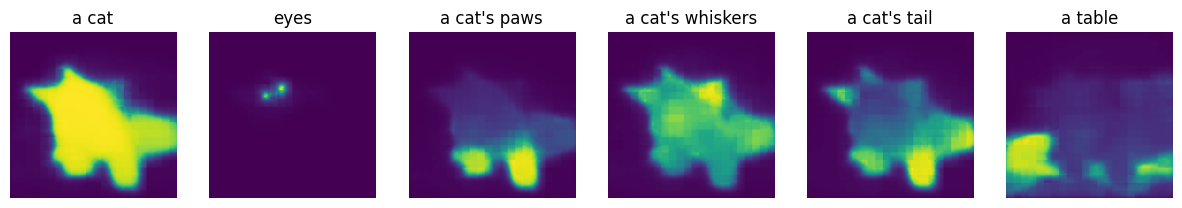

In [10]:
# Load model
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")


# Define text prompts (multiple supported)
texts = ["a cat", "eyes", "a cat's paws", "a cat's whiskers",
         "a cat's tail", "a table"]
# Process inputs
inputs = processor(text=texts, images=[image]*len(texts), return_tensors="pt", padding=True)

# Predict
with torch.no_grad():
    outputs = model(**inputs)

# Visualize masks
fig, axes = plt.subplots(1, len(texts), figsize=(15,5))
for idx, (text, mask) in enumerate(zip(texts, outputs.logits)):
    axes[idx].imshow(mask.sigmoid().numpy(), cmap='viridis')
    axes[idx].set_title(text)
    axes[idx].axis('off')
plt.show()

In [13]:
# #title Enhanced Segmentation Visualization with Probability Sidebars

# # Create figure
# fig = plt.figure(figsize=(20, 5 * len(texts)))  # Adjust height based on number of texts

# for idx, (text, mask) in enumerate(zip(texts, outputs.logits)):
#     # Create grid layout for this segmentation
#     gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.05)

#     # Main image with mask overlay
#     ax0 = plt.subplot(gs[0])
#     img_array = np.array(image)

#     # Resize mask to match image
#     mask_resized = interpolate(
#         mask.unsqueeze(0).unsqueeze(0),
#         size=img_array.shape[:2],
#         mode='bilinear'
#     ).squeeze().numpy()
#     mask_norm = 1 / (1 + np.exp(-mask_resized))

#     # Display
#     ax0.imshow(img_array)
#     overlay = ax0.imshow(mask_norm, cmap='viridis', alpha=0.5)
#     ax0.set_title(f"'{text}' Segmentation", fontsize=12, pad=10)
#     ax0.axis('off')

#     # Add colorbar sidebar
#     ax1 = plt.subplot(gs[1])
#     divider = make_axes_locatable(ax1)
#     cax = divider.append_axes("right", size="20%", pad=0.1)

#     # Create histogram of probabilities
#     hist_data = mask_norm.flatten()
#     hist_data = hist_data[hist_data > 0.1]  # Filter very low probabilities

#     ax1.hist(hist_data, bins=50, orientation='horizontal', color='green')
#     ax1.set_xlabel('Pixel Count')
#     ax1.set_ylabel('Mask Probability')
#     ax1.set_title('Probability Distribution', fontsize=10)
#     ax1.grid(True, alpha=0.3)

#     # Add colorbar
#     plt.colorbar(overlay, cax=cax, label='Mask Confidence')

# plt.tight_layout()
# plt.show()

Mean confidence values for the segmented classes

In [12]:
for idx, (text, mask) in enumerate(zip(texts, outputs.logits)):
    mask_norm = mask.sigmoid().numpy()
    mean_confidence = mask_norm.mean()
    print(mean_confidence)

0.34097892
0.003336427
0.10671746
0.11317652
0.12287193
0.13684021
